In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [71]:
dataset = pd.read_csv('/housing.csv')
dataset = dataset.dropna()
print("First ten rows of the dataset: ")
dataset.head(10)

First ten rows of the dataset: 


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY
5,-122.25,37.85,52,919,213.0,413,193,4.0368,269700,NEAR BAY
6,-122.25,37.84,52,2535,489.0,1094,514,3.6591,299200,NEAR BAY
7,-122.25,37.84,52,3104,687.0,1157,647,3.1200,241400,NEAR BAY
8,-122.26,37.84,42,2555,665.0,1206,595,2.0804,226700,NEAR BAY
9,-122.25,37.84,52,3549,707.0,1551,714,3.6912,261100,NEAR BAY


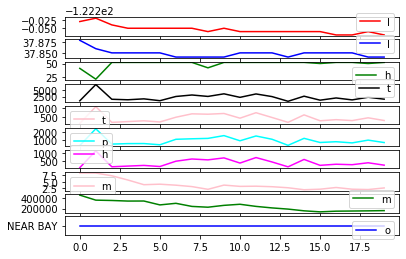

In [81]:
x_data = range(0, 20)
dataset1 = dataset[:20]
fig, ax = plt.subplots(10)

ax[0].plot(x_data, dataset1['longitude'], label='longitude', color='red')
ax[0].legend('longitude')
ax[1].plot(x_data, dataset1['latitude'], label='latitude', color='blue')
ax[1].legend('latitude')
ax[2].plot(x_data, dataset1['housing_median_age'], label='housing_median_age', color='green')
ax[2].legend('housing_median_age')
ax[3].plot(x_data, dataset1['total_rooms'], label='total_rooms', color='black')
ax[3].legend('total_rooms')
ax[4].plot(x_data, dataset1['total_bedrooms'], label='total_bedrooms', color='pink')
ax[4].legend('total_bedrooms')
ax[5].plot(x_data, dataset1['population'], label='population', color='cyan')
ax[5].legend("population")
ax[6].plot(x_data, dataset1['households'], label='households', color='magenta')
ax[6].legend('households')
ax[7].plot(x_data, dataset1['median_income'], label='median_income', color='pink')
ax[7].legend('median_income')
ax[8].plot(x_data, dataset1['median_house_value'], label='median_house_value', color='green')
ax[8].legend('median_house_value')
ax[9].plot(x_data, dataset1['ocean_proximity'], label='ocean_proximity', color='blue')
ax[9].legend('ocean_proximity')


In [0]:
Y = dataset['median_house_value']
X = dataset.loc[:,'longitude':'median_income']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, 
                                                    random_state=2003)
x_train_np = x_train.to_numpy() 
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy() 
y_test_np = y_test.to_numpy()


In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__() 
    self.batch_size = batch_size 
    self.inputs = inputs
    self.outputs = outputs
    self.input_layer = Conv1d(inputs, batch_size, 1)
    self.max_pooling_layer = MaxPool1d(1)
    self.conv_layer = Conv1d(batch_size, 17, 1)
    self.flatten_layer = Flatten()
    self.linear_layer = Linear(17, 15)
    self.output_layer = Linear(15, outputs)
  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs, 1))
    output = relu(self.input_layer(input))
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer(output))
    output = self.flatten_layer(output)
    output = self.linear_layer(output)
    output = self.output_layer(output) 
    return output

In [0]:
from torch.optim import RMSprop as RMS
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

batch_size = 15
model = CnnRegressor(batch_size, X.shape[1], 1)
model.cuda()

In [0]:
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss() 
  score_metric = R2Score()
  avg_loss = 0
  avg_score = 0
  count = 0
  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    score_metric.update([predictions, output]) 
    score = score_metric.compute()
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss += loss.item() 
    avg_score += score 
    count += 1
  
  return avg_loss / count, avg_score / count

epochs = 100
optimizer = RMS(model.parameters(), lr=0.0001, momentum=0.9)
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)
  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " 
        + str(avg_r2_score))

torch.save(model.state_dict(), '1117675_1dconv_reg')


In [0]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
avg_loss, avg_r2_score = model_loss(model, loader) 
print("The model's L1 loss is: " + str(avg_loss)) 
print("The model's R^2 score is: " + str(avg_r2_score))